In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor


# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1))
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula


#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
lv_grouped = lv_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()

In [4]:
# '제모제'만 빼서 df생성
item = '제모제'
grouped_by = 'week'
day_lv_grouped_w_item = pd.merge(day_lv_grouped.loc[day_lv_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_lv_grouped_w_sns_item = pd.merge(day_lv_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
lv_day_w = day_lv_grouped_w_sns_item[selected_cols]

# 주단위로 종합해보기

In [5]:
lv_week_w = lv_day_w.copy()
lv_week_w = addDayWeek(lv_week_w)

cols_Ineed = ['week','category', 'qty', 'temp', 'rain', 'cloud', 'wind', 'humid','hpa', 'sun_time', 'lgt_time', 'snow',
              'SO2', 'CO', 'O3', 'NO2', 'PM10','PM25',
              'pm_blog', 'pm_twitter', 'pm_news', 'pm_total', 
              'health_blog','health_twitter', 'health_news', 'health_total',
              'date_blog','date_twitter', 'date_news', 'date_total',
              'br_blog', 'br_twitter','br_news', 'br_total',
              'hobby_blog', 'hobby_twitter', 'hobby_news','hobby_total']
lv_week_w = lv_week_w[cols_Ineed]

In [6]:
list_col = ['temp', 'rain', 'cloud', 'wind', 'humid','hpa', 'sun_time', 'lgt_time', 'snow',
              'SO2', 'CO', 'O3', 'NO2', 'PM10','PM25',
              'pm_blog', 'pm_twitter', 'pm_news', 'pm_total', 
              'health_blog','health_twitter', 'health_news', 'health_total',
              'date_blog','date_twitter', 'date_news', 'date_total',
              'br_blog', 'br_twitter','br_news', 'br_total',
              'hobby_blog', 'hobby_twitter', 'hobby_news','hobby_total']
lowVIF(lv_week_w,40,list_col)

list_col = ['temp', 'rain', 'cloud', 'wind', 'humid','hpa', 'sun_time', 'lgt_time', 'snow',
              'SO2', 'CO', 'O3', 'NO2', 'PM10','PM25',]
lv_week_w = lv_week_w[['week','qty']+list_col].groupby('week').mean().reset_index()
# gs_week_w.tail(2)

# week: 1~105 = 2016~2017년
# week: 106~157 = 2018년
train_data = lv_week_w.loc[lv_week_w.week <=105]
test_date = lv_week_w.loc[lv_week_w.week >105]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
combined = lv_week_w.loc[:,'temp':'PM25']
target = lv_week_w.loc[:,'qty']

In [7]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [8]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 15
Number of nun-numerical columns with no nan values : 0


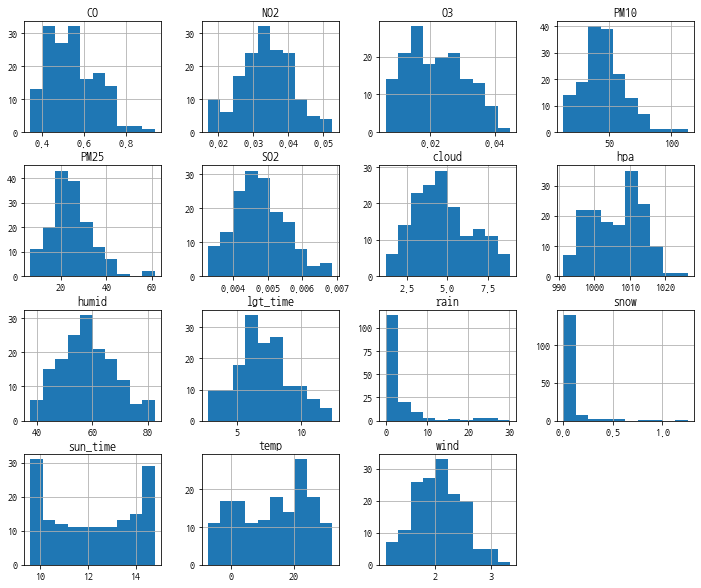

In [9]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

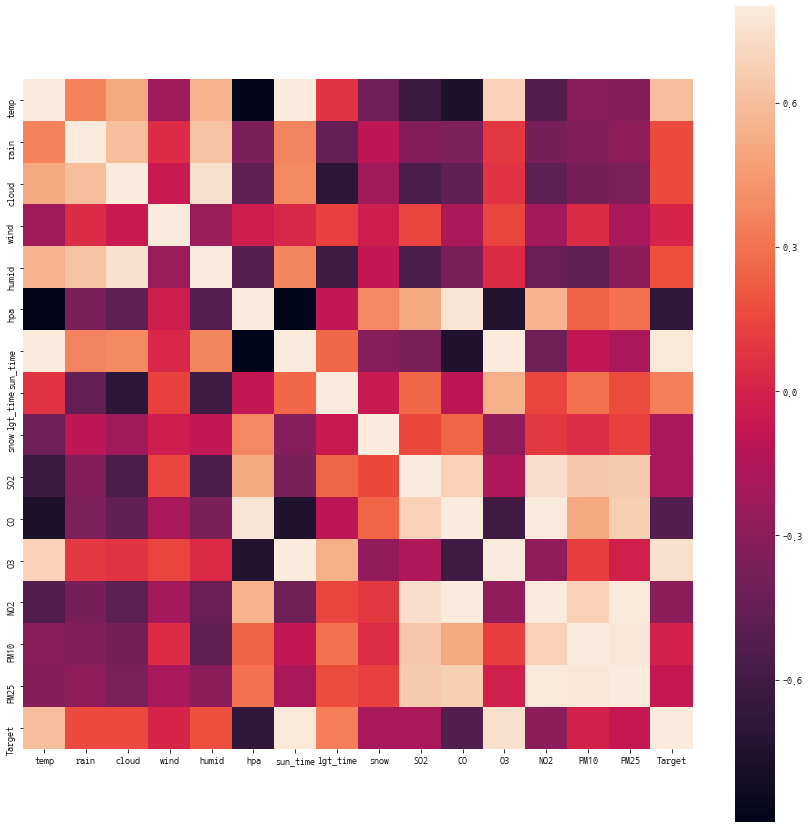

In [10]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [10]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 15 columns before encoding categorical features
There are 15 columns after encoding categorical features


In [11]:
# 여기서 이코드으 제작자는 수동으로 훈련/검증셋을 나눔
# 105주 기준으로 나누겠음
cut_line = 106
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()
train.shape

(106, 15)

In [12]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
# optimizer에 여러 방식이 있다.
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0717 15:37:45.099961  2236 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 15:37:45.114922  2236 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 15:37:45.117913  2236 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0717 15:37:45.172790  2236 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


#### =========='xxxxyyyyzzzz.hdf5'파일이 안주어지면 실행.(있으면 실행 필요없음)==========

In [13]:
# 인공 신경망에 의해 생성된 weight 자료를 저장하기 위해서
checkpoint_name = 'LV-'+item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 

# save_best_only값이 저장되어, 모든 weight값을 저장하지 않고, val_loss값이 줄어들때마다(적을수록 좋다.) 저장
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [14]:
# 예제에서는 target을 대회에서 주는 target데이터를 기준으로 미리 train데이터와 맞춰졌있지만
# gs/lv데이터는 아니다. 그래서 위에서 나누는 기준으로 삼은cut_line=106을 이용하여 데이터 사이즈를 맞춰준다.
# 아니면 애시당초에(맨처음에) 훈련용 데이터와 타겟을 만들어 놓는것도 좋다.
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0717 15:37:48.259710  2236 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0717 15:37:48.373914  2236 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 84 samples, validate on 22 samples
Epoch 1/500
84/84 [==============================] - 0s 3ms/step - loss: 1616.5065 - mean_absolute_error: 1616.5065 - val_loss: 867.2692 - val_mean_absolute_error: 867.2692

Epoch 00001: val_loss improved from inf to 867.26917, saving model to LV-제모제week-Weights-001--867.26917.hdf5
Epoch 2/500
84/84 [==============================] - 0s 107us/step - loss: 1578.5995 - mean_absolute_error: 1578.5995 - val_loss: 807.5000 - val_mean_absolute_error: 807.5000

Epoch 00002: val_loss improved from 867.26917 to 807.50000, saving model to LV-제모제week-Weights-002--807.50000.hdf5
Epoch 3/500
84/84 [==============================] - 0s 107us/step - loss: 1505.2231 - mean_absolute_error: 1505.2231 - val_loss: 687.6830 - val_mean_absolute_error: 687.6830

Epoch 00003: val_loss improved from 807.50000 to 687.68298, saving model to LV-제모제week-Weights-003--687.68298.hdf5
Epoch 4/500
84/84 [==============================] - 0s 107us/step - loss: 1380.0997 - mean

84/84 [==============================] - 0s 154us/step - loss: 1067.2012 - mean_absolute_error: 1067.2012 - val_loss: 419.8724 - val_mean_absolute_error: 419.8724

Epoch 00035: val_loss did not improve from 304.90259
Epoch 36/500
84/84 [==============================] - 0s 107us/step - loss: 1065.5167 - mean_absolute_error: 1065.5167 - val_loss: 471.3936 - val_mean_absolute_error: 471.3936

Epoch 00036: val_loss did not improve from 304.90259
Epoch 37/500
84/84 [==============================] - 0s 107us/step - loss: 1062.2403 - mean_absolute_error: 1062.2403 - val_loss: 502.1100 - val_mean_absolute_error: 502.1100

Epoch 00037: val_loss did not improve from 304.90259
Epoch 38/500
84/84 [==============================] - 0s 119us/step - loss: 1058.2947 - mean_absolute_error: 1058.2947 - val_loss: 522.8013 - val_mean_absolute_error: 522.8013

Epoch 00038: val_loss did not improve from 304.90259
Epoch 39/500
84/84 [==============================] - 0s 95us/step - loss: 1051.3765 - mean_a

84/84 [==============================] - 0s 131us/step - loss: 635.6459 - mean_absolute_error: 635.6459 - val_loss: 708.0435 - val_mean_absolute_error: 708.0435

Epoch 00071: val_loss did not improve from 304.90259
Epoch 72/500
84/84 [==============================] - 0s 154us/step - loss: 641.4085 - mean_absolute_error: 641.4085 - val_loss: 677.6995 - val_mean_absolute_error: 677.6995

Epoch 00072: val_loss did not improve from 304.90259
Epoch 73/500
84/84 [==============================] - 0s 95us/step - loss: 627.2559 - mean_absolute_error: 627.2559 - val_loss: 893.9863 - val_mean_absolute_error: 893.9863

Epoch 00073: val_loss did not improve from 304.90259
Epoch 74/500
84/84 [==============================] - 0s 131us/step - loss: 659.2812 - mean_absolute_error: 659.2812 - val_loss: 623.5474 - val_mean_absolute_error: 623.5474

Epoch 00074: val_loss did not improve from 304.90259
Epoch 75/500
84/84 [==============================] - 0s 119us/step - loss: 643.7700 - mean_absolute_e

84/84 [==============================] - 0s 142us/step - loss: 517.8310 - mean_absolute_error: 517.8310 - val_loss: 597.5770 - val_mean_absolute_error: 597.5770

Epoch 00107: val_loss did not improve from 304.90259
Epoch 108/500
84/84 [==============================] - 0s 107us/step - loss: 514.3652 - mean_absolute_error: 514.3652 - val_loss: 490.6444 - val_mean_absolute_error: 490.6444

Epoch 00108: val_loss did not improve from 304.90259
Epoch 109/500
84/84 [==============================] - 0s 95us/step - loss: 531.4342 - mean_absolute_error: 531.4342 - val_loss: 509.5783 - val_mean_absolute_error: 509.5783

Epoch 00109: val_loss did not improve from 304.90259
Epoch 110/500
84/84 [==============================] - 0s 119us/step - loss: 534.5017 - mean_absolute_error: 534.5017 - val_loss: 587.7996 - val_mean_absolute_error: 587.7996

Epoch 00110: val_loss did not improve from 304.90259
Epoch 111/500
84/84 [==============================] - 0s 166us/step - loss: 508.5255 - mean_absolu


Epoch 00142: val_loss did not improve from 304.90259
Epoch 143/500
84/84 [==============================] - 0s 107us/step - loss: 577.4148 - mean_absolute_error: 577.4148 - val_loss: 444.4885 - val_mean_absolute_error: 444.4885

Epoch 00143: val_loss did not improve from 304.90259
Epoch 144/500
84/84 [==============================] - 0s 107us/step - loss: 562.4715 - mean_absolute_error: 562.4715 - val_loss: 334.3602 - val_mean_absolute_error: 334.3602

Epoch 00144: val_loss did not improve from 304.90259
Epoch 145/500
84/84 [==============================] - 0s 107us/step - loss: 520.5130 - mean_absolute_error: 520.5130 - val_loss: 595.5611 - val_mean_absolute_error: 595.5611

Epoch 00145: val_loss did not improve from 304.90259
Epoch 146/500
84/84 [==============================] - 0s 107us/step - loss: 601.3341 - mean_absolute_error: 601.3341 - val_loss: 539.5718 - val_mean_absolute_error: 539.5718

Epoch 00146: val_loss did not improve from 304.90259
Epoch 147/500
84/84 [=========


Epoch 00178: val_loss did not improve from 304.90259
Epoch 179/500
84/84 [==============================] - 0s 142us/step - loss: 530.5354 - mean_absolute_error: 530.5354 - val_loss: 488.8153 - val_mean_absolute_error: 488.8153

Epoch 00179: val_loss did not improve from 304.90259
Epoch 180/500
84/84 [==============================] - 0s 154us/step - loss: 487.1186 - mean_absolute_error: 487.1186 - val_loss: 385.5185 - val_mean_absolute_error: 385.5185

Epoch 00180: val_loss did not improve from 304.90259
Epoch 181/500
84/84 [==============================] - 0s 131us/step - loss: 481.2277 - mean_absolute_error: 481.2277 - val_loss: 349.1510 - val_mean_absolute_error: 349.1510

Epoch 00181: val_loss did not improve from 304.90259
Epoch 182/500
84/84 [==============================] - 0s 142us/step - loss: 485.8340 - mean_absolute_error: 485.8340 - val_loss: 358.8733 - val_mean_absolute_error: 358.8733

Epoch 00182: val_loss did not improve from 304.90259
Epoch 183/500
84/84 [=========


Epoch 00249: val_loss did not improve from 270.38840
Epoch 250/500
84/84 [==============================] - 0s 142us/step - loss: 514.5066 - mean_absolute_error: 514.5066 - val_loss: 314.4293 - val_mean_absolute_error: 314.4293

Epoch 00250: val_loss did not improve from 270.38840
Epoch 251/500
84/84 [==============================] - 0s 107us/step - loss: 471.7458 - mean_absolute_error: 471.7458 - val_loss: 333.6937 - val_mean_absolute_error: 333.6937

Epoch 00251: val_loss did not improve from 270.38840
Epoch 252/500
84/84 [==============================] - 0s 107us/step - loss: 490.2317 - mean_absolute_error: 490.2317 - val_loss: 440.7029 - val_mean_absolute_error: 440.7029

Epoch 00252: val_loss did not improve from 270.38840
Epoch 253/500
84/84 [==============================] - 0s 107us/step - loss: 488.1865 - mean_absolute_error: 488.1865 - val_loss: 379.1762 - val_mean_absolute_error: 379.1762

Epoch 00253: val_loss did not improve from 270.38840
Epoch 254/500
84/84 [=========

84/84 [==============================] - 0s 131us/step - loss: 449.6489 - mean_absolute_error: 449.6489 - val_loss: 325.1820 - val_mean_absolute_error: 325.1820

Epoch 00321: val_loss did not improve from 268.29807
Epoch 322/500
84/84 [==============================] - 0s 154us/step - loss: 435.9077 - mean_absolute_error: 435.9077 - val_loss: 343.0239 - val_mean_absolute_error: 343.0239

Epoch 00322: val_loss did not improve from 268.29807
Epoch 323/500
84/84 [==============================] - 0s 119us/step - loss: 429.3384 - mean_absolute_error: 429.3384 - val_loss: 344.2620 - val_mean_absolute_error: 344.2620

Epoch 00323: val_loss did not improve from 268.29807
Epoch 324/500
84/84 [==============================] - 0s 119us/step - loss: 481.4378 - mean_absolute_error: 481.4378 - val_loss: 319.5287 - val_mean_absolute_error: 319.5287

Epoch 00324: val_loss did not improve from 268.29807
Epoch 325/500
84/84 [==============================] - 0s 142us/step - loss: 427.6770 - mean_absol


Epoch 00356: val_loss improved from 256.36523 to 242.30450, saving model to LV-제모제week-Weights-356--242.30450.hdf5
Epoch 357/500
84/84 [==============================] - 0s 214us/step - loss: 426.0095 - mean_absolute_error: 426.0095 - val_loss: 273.2804 - val_mean_absolute_error: 273.2804

Epoch 00357: val_loss did not improve from 242.30450
Epoch 358/500
84/84 [==============================] - 0s 154us/step - loss: 439.8480 - mean_absolute_error: 439.8480 - val_loss: 354.6836 - val_mean_absolute_error: 354.6836

Epoch 00358: val_loss did not improve from 242.30450
Epoch 359/500
84/84 [==============================] - 0s 131us/step - loss: 453.9418 - mean_absolute_error: 453.9418 - val_loss: 374.8107 - val_mean_absolute_error: 374.8107

Epoch 00359: val_loss did not improve from 242.30450
Epoch 360/500
84/84 [==============================] - 0s 166us/step - loss: 433.3177 - mean_absolute_error: 433.3177 - val_loss: 363.8497 - val_mean_absolute_error: 363.8497

Epoch 00360: val_loss

84/84 [==============================] - 0s 154us/step - loss: 410.3923 - mean_absolute_error: 410.3923 - val_loss: 308.6606 - val_mean_absolute_error: 308.6606

Epoch 00392: val_loss did not improve from 235.75893
Epoch 393/500
84/84 [==============================] - 0s 119us/step - loss: 417.9790 - mean_absolute_error: 417.9790 - val_loss: 287.1200 - val_mean_absolute_error: 287.1200

Epoch 00393: val_loss did not improve from 235.75893
Epoch 394/500
84/84 [==============================] - 0s 107us/step - loss: 415.5914 - mean_absolute_error: 415.5914 - val_loss: 288.7081 - val_mean_absolute_error: 288.7081

Epoch 00394: val_loss did not improve from 235.75893
Epoch 395/500
84/84 [==============================] - 0s 119us/step - loss: 400.1595 - mean_absolute_error: 400.1595 - val_loss: 294.5385 - val_mean_absolute_error: 294.5385

Epoch 00395: val_loss did not improve from 235.75893
Epoch 396/500
84/84 [==============================] - 0s 107us/step - loss: 425.2377 - mean_absol

84/84 [==============================] - 0s 178us/step - loss: 406.9199 - mean_absolute_error: 406.9199 - val_loss: 307.0818 - val_mean_absolute_error: 307.0818

Epoch 00463: val_loss did not improve from 230.75093
Epoch 464/500
84/84 [==============================] - 0s 166us/step - loss: 389.0098 - mean_absolute_error: 389.0098 - val_loss: 301.4115 - val_mean_absolute_error: 301.4115

Epoch 00464: val_loss did not improve from 230.75093
Epoch 465/500
84/84 [==============================] - 0s 142us/step - loss: 372.8021 - mean_absolute_error: 372.8021 - val_loss: 246.8118 - val_mean_absolute_error: 246.8118

Epoch 00465: val_loss did not improve from 230.75093
Epoch 466/500
84/84 [==============================] - 0s 131us/step - loss: 360.9887 - mean_absolute_error: 360.9887 - val_loss: 309.0336 - val_mean_absolute_error: 309.0336

Epoch 00466: val_loss did not improve from 230.75093
Epoch 467/500
84/84 [==============================] - 0s 142us/step - loss: 366.9025 - mean_absol

84/84 [==============================] - 0s 119us/step - loss: 358.5726 - mean_absolute_error: 358.5726 - val_loss: 278.2448 - val_mean_absolute_error: 278.2448

Epoch 00499: val_loss did not improve from 230.75093
Epoch 500/500
84/84 [==============================] - 0s 119us/step - loss: 352.3442 - mean_absolute_error: 352.3442 - val_loss: 309.0593 - val_mean_absolute_error: 309.0593

Epoch 00500: val_loss did not improve from 230.75093


#### ====================================================================================================

In [15]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
wights_file = 'LV-제모제week-Weights-421--230.75093.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [16]:
# rf나,XGB회귀 분석을위한 훈련/검증 dataset생산
train_X, val_X, train_y, val_y = train_test_split(train, target[:cut_line], test_size = 0.25, random_state = 14)

In [17]:
# RandomForest 회귀분석
model = RandomForestRegressor()
model.fit(train_X,train_y)

# Get the mean absolute error on the validation data
RFpredicted = model.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  318.6449735449736


In [18]:
# XGBRegressor 회귀분석
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

[15:38:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE =  340.5726652599517


In [19]:
# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)

combined = lv_week_w.loc[:,'temp':'PM25']
target = lv_week_w.loc[:,'qty']
# RandomForest 회귀분석 예측 qty생산
RFpredicted = model.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)

result_df = pd.DataFrame()
result_df['week'] = lv_week_w['week']
result_df['qty'] = lv_week_w.loc[:,'qty']

print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions

print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

keras 신경망 predictions (157, 1)
randomforest 예상 (157,)
XGBpredictions (157,)


In [21]:
df_graph = result_df.loc[:,['week','keras_qty','rf_qty','xgb_qty','qty']]
df_graph['week'] = pd.to_datetime(df_graph['week'])

In [1]:
# 2016
df_graph = result_df.loc[result_df.week <=53]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='orange')
plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.legend()
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
plt.show()

NameError: name 'result_df' is not defined

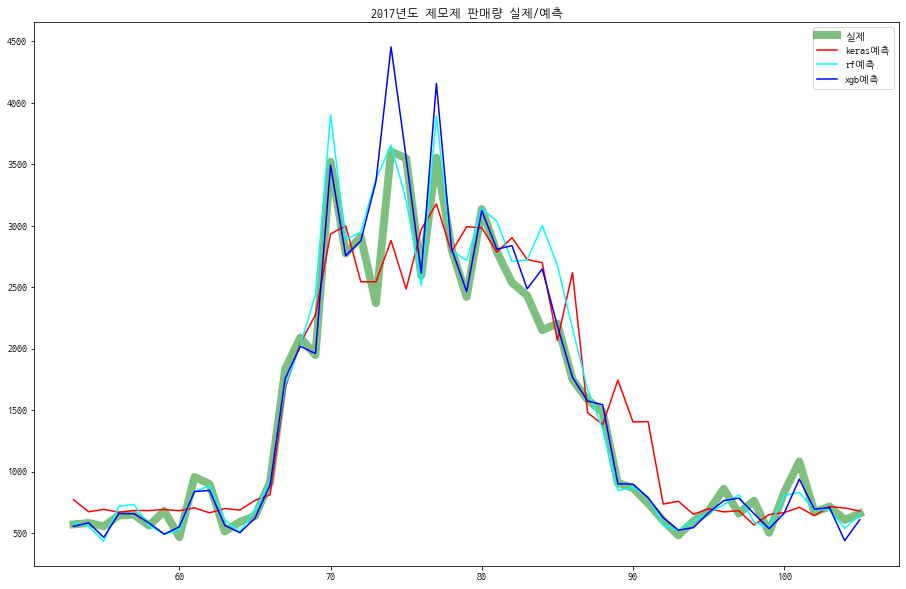

In [23]:
# 2017
df_graph = result_df.loc[(result_df.week >=53)&(result_df.week <=105)]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2017',item ))
plt.legend()
plt.show()

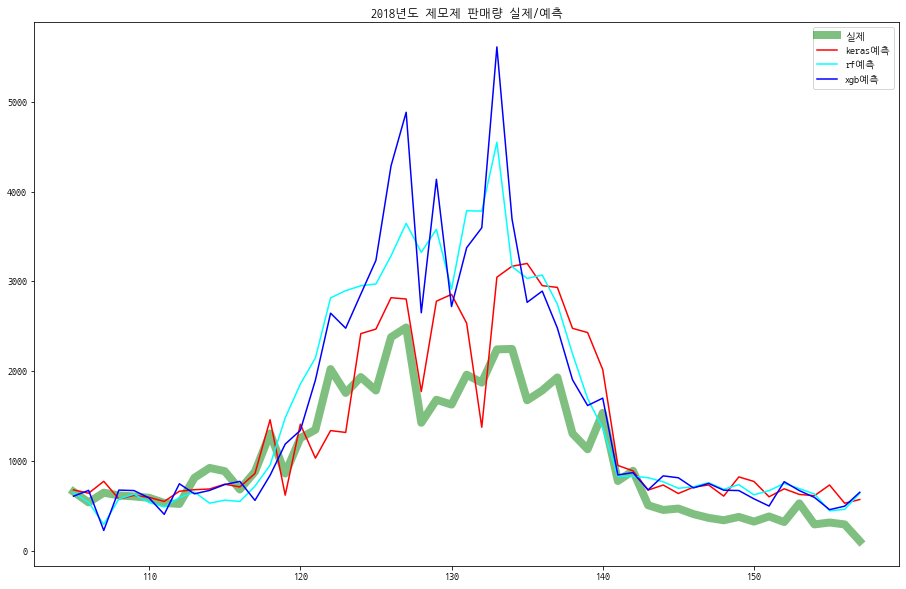

In [24]:
# 2018
df_graph = result_df.loc[(result_df.week >=105)]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2018',item ))
plt.legend()
plt.show()

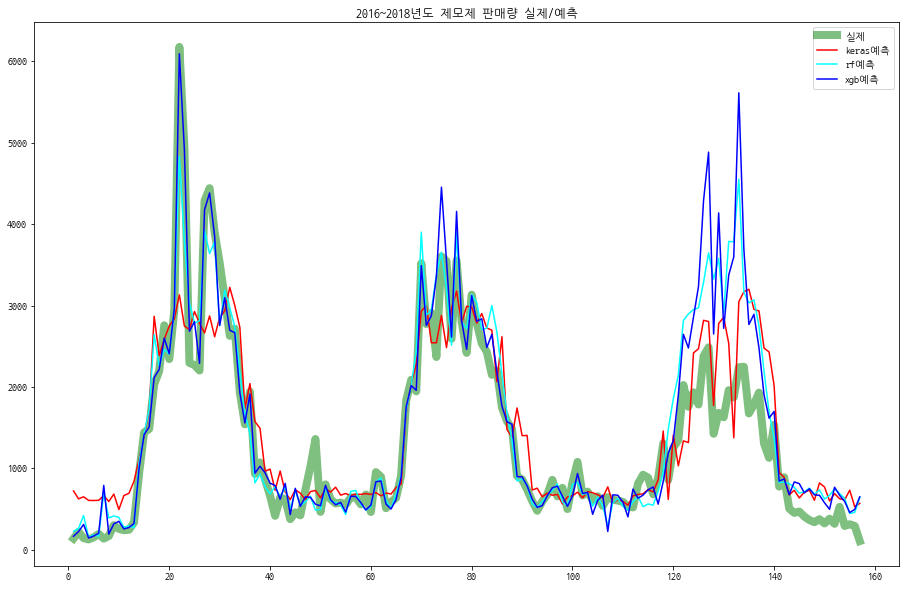

In [25]:
# 2016~2018
plt.figure(figsize=(15.5, 10))
plt.plot(result_df.week,result_df.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(result_df.week,result_df.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(result_df.week,result_df.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(result_df.week,result_df.xgb_qty, ls='-', label='xgb예측', color='b')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
plt.legend()
plt.show()

In [ ]:
# 날씨+sns와 '생수' 을 사용하면 2017까진 적당하고 2018년도는 예측율 급락
#  -> 과적합화 발생
# 날씨와 '생수' 판매량만 이용하니 ㅇㅋ

In [26]:
orginal_mean = np.mean(result_df.qty)
result_df['qtyMinusMean'] = (result_df.qty - orginal_mean )
result_df['qtyMinusMeanSquared'] = (result_df.qty - orginal_mean )**2

result_df['kerasMiunsMeanSquared'] = (result_df.keras_qty - orginal_mean)**2
result_df['rfMiunsMeanSquared'] = (result_df.rf_qty - orginal_mean)**2
result_df['xgbMiunsMeanSquared'] = (result_df.xgb_qty - orginal_mean)**2

print('kreas R-sq',(sum(result_df['kerasMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('rf R-sq',(sum(result_df['rfMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('xgb R-sq',(sum(result_df['xgbMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))

kreas R-sq 0.7662173931992837
rf R-sq 1.2242968862830463
xgb R-sq 1.402944454347196


In [27]:
path = 'D:/project/contest/data/result/'
result_df.to_csv(path+item+'_'+grouped_by+'_predict.csv', encoding='utf-8', index=False)